In [1]:
# Same stuff from last time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10, 10)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
# Importing the csv
climate_essay_df = pd.read_csv('data_noID.csv')

# How big is this dataframe
climate_essay_df.shape

(1793, 104)

In [3]:
subsetted_df = climate_essay_df[climate_essay_df['trt1'] == 1]
subsetted_df = subsetted_df[['trt1', 'don', 'essay']]
subsetted_df = subsetted_df.reset_index(drop = True)
subsetted_df.shape

(589, 3)

In [4]:
subsetted_df['big_donator'] = (subsetted_df['don'] > 8.5)
subsetted_df['big_donator'] = subsetted_df['big_donator'].astype(int)
subsetted_df.head()

,trt1,don,essay,big_donator
0,1,15.0,"Dear Adelyn, \n Today is January 7, 2015. I kn...",1
1,1,0.0,To whom it may concern in 2050:\n\nThis is 201...,0
2,1,19.0,"Dear son,\n This is your mother from 2015 w...",1
3,1,15.0,"Dear J-Swag,\n I want you to know how much I l...",1
4,1,0.0,"Dear Kailey,\nYou will be reading this in the ...",0


In [5]:
# Creating train (in-sample) and test (out-of-sample) sets
train_df, test_df = train_test_split(subsetted_df, 
                                     test_size = 0.2,       # 80/20 train/test split
                                     random_state = 123)    # Making sure everyone gets the same thing

In [6]:
# Converting the Panda's formal dataframe column into a standard vector of strings
train_essays = train_df['essay'].values
test_essays = test_df['essay'].values

# Creating a CountVectorizer object
word_counter = CountVectorizer()

# Fitting this word-counter on our train essays
word_counter.fit(train_essays)

# Transforming the train and test set essays into the word count form
test_word_counts = word_counter.transform(test_essays)
train_word_counts = word_counter.transform(train_essays)

# Dimensionality Reduction and SVM

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tSNE is similar to PCA in that it reduces dimensionality of your data, however they are different. Notably, PCA outputs a function to transform new data, while tSNE does not. Additionally, they reduce dimensions in different ways: PCA reduces in a way that maintains the variability of the original data, while tSNE reduces in a way that maintains distances between points. Additionally tSNE is a nonlinear dimensionality reduction, where PCA is not.

In [8]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [9]:
test_Y = test_df['big_donator'].values
train_Y = train_df['big_donator'].values

In [10]:
def train_model(model_type, new_dim):
    
    # Set up
    if new_dim < 999:
        dim_reduction = PCA(n_components = new_dim, random_state=123)
        dim_reduction.fit(train_word_counts.todense())
        train_reduced = dim_reduction.transform(train_word_counts.todense())
        test_reduced = dim_reduction.transform(test_word_counts.todense())
    else:
        train_reduced = train_word_counts
        test_reduced = test_word_counts
    
    # Fitting model
    if (model_type == 'svm'):
        model = SVC(kernel = 'linear', C = 0.0001, random_state=123)
        
    elif (model_type == 'decision_tree'):
        model = DecisionTreeClassifier(min_samples_split = 100, max_depth=5, random_state=123)
        
    elif (model_type == 'random_forest'):
        model = RandomForestClassifier(n_estimators= 100, max_depth=5, min_samples_split=100, random_state=123)
    model.fit(X = train_reduced,
              y = train_Y)
    
    # Magic plotting code - Only tested with new_dim = 2 
    if model_type == 'svm':
        if new_dim == 2:
            h = 0.2
            x_min, x_max = train_reduced[:,0].min() - 1, train_reduced[:, 0].max() + 1
            y_min, y_max = train_reduced[:,1].min() - 1, train_reduced[:, 1].max() + 1
            xx, yy = np.meshgrid(
                np.arange(x_min, x_max, h),
                np.arange(y_min, y_max, h))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx,yy,Z,cmap=plt.cm.viridis, alpha=0.8)
            plt.scatter(train_reduced[:,0],train_reduced[:,1],c=train_Y, cmap = plt.cm.viridis)
            plt.show()
    
    # Evaluation
    print("TRAIN SET")
    train_predictions = model.predict(train_reduced)
    train_accuracy = accuracy_score(train_predictions, train_Y)
    print('The training set accuracy is %0.6f' % train_accuracy)
    confusion_M = confusion_matrix(train_predictions, train_Y)
    print(confusion_M)
    print("\nTEST SET")
    test_predictions = model.predict(test_reduced)
    test_accuracy = accuracy_score(test_predictions, test_Y)
    print('The test set accuracy is %0.6f' % test_accuracy)
    confusion_M = confusion_matrix(test_predictions, test_Y)
    print(confusion_M)
    
    return(model)

<br><br><br><br>

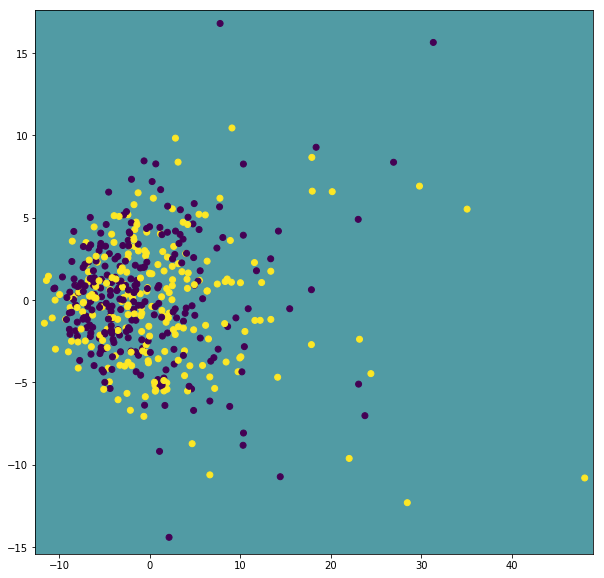

TRAIN SET
The training set accuracy is 0.528662
[[249 222]
 [  0   0]]

TEST SET
The test set accuracy is 0.466102
[[55 63]
 [ 0  0]]


In [11]:
svm = train_model('svm', 2)

<br><br><br>

In [12]:
decision_tree = train_model('decision_tree', 1000)

TRAIN SET
The training set accuracy is 0.653928
[[161  75]
 [ 88 147]]

TEST SET
The test set accuracy is 0.508475
[[30 33]
 [25 30]]


<br><br><br>

In [13]:
random_forest = train_model('random_forest', 1000)

TRAIN SET
The training set accuracy is 0.736730
[[247 122]
 [  2 100]]

TEST SET
The test set accuracy is 0.533898
[[51 51]
 [ 4 12]]


<br><br><br>

# Logistic Regression Revisitted

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [15]:
class PyTorchLogRegress(torch.nn.Module):
    
    def __init__(self):
        super(PyTorchLogRegress, self).__init__()
        
        self.linear_layer = torch.nn.Linear(5, 1)
        
        
    def forward(self, x):
        linear_output = self.linear_layer(x)
        logistic_output = torch.nn.functional.sigmoid(linear_output)
        return(logistic_output)


# Make it
classifier = PyTorchLogRegress()

In [16]:
dim_reduction = PCA(n_components = 5, random_state=123)
dim_reduction.fit(train_word_counts.todense())
train_reduced = dim_reduction.transform(train_word_counts.todense())
test_reduced = dim_reduction.transform(test_word_counts.todense())

In [17]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters())

In [18]:
train_torch_X = Variable(torch.from_numpy(train_reduced)).type(torch.FloatTensor)
train_torch_Y = Variable(torch.from_numpy(train_Y)).type(torch.FloatTensor).unsqueeze(dim = 1)

In [19]:
loss_list = []

for i in range(1000):
    optimizer.zero_grad()
    predictions = classifier(train_torch_X)
    loss = loss_function(predictions, train_torch_Y)
    loss_list.append(loss.data[0])
    loss.backward()
    optimizer.step()

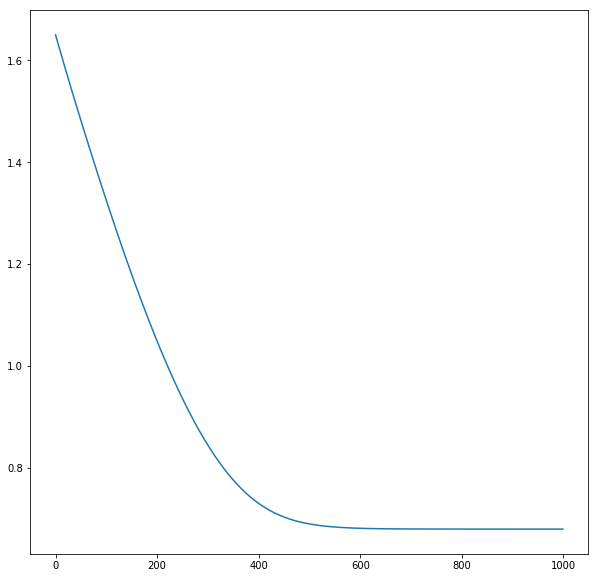

In [20]:
plt.plot(loss_list)